# Learning Rate

Die Learning Rate (LR) legt fest, wie stark die Gewichte der Neuronen pro Trainingslauf angepasst werden, und beeinflusst somit direkt die Trainingsgeschwindigkeit des Netzwerkes. Die LR ist ein wichtiger Hyperparameter: Ist sie zu niedrig, kovergiert das Model nur sehr langsam. Ist sie zu hoch, kann die Fehlerfunktion unter Umständen überhaupt nicht minimiert werden. In diesem Notebook werden diese Fälle demonstriert, sowie der LR Finder ausprobiert.

Zuerst wieder das Datenset vorbereiten:

['Ahorn', 'Birke', 'Eiche', 'Kastanie']


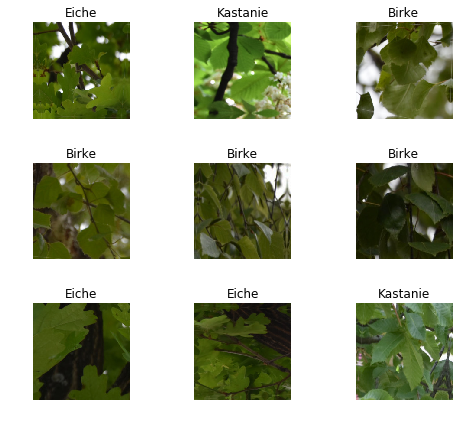

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import error_rate

path = Path('datasets/leaves')

np.random.seed(1337)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, bs=10,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)
data.show_batch(rows=3, figsize=(7,6))
print(data.classes)

## LR gut

Der Default-Wert für die LR ist hier 0.003

In [13]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.894652,0.345743,0.134078,00:04
1,0.546842,0.270201,0.111732,00:04
2,0.450794,0.259190,0.089385,00:04
3,0.355511,0.255995,0.089385,00:04


## LR zu niedrig

In [15]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(4, max_lr=slice(None, 0.00001, None))

epoch,train_loss,valid_loss,error_rate,time
0,1.706942,1.473615,0.670391,00:04
1,1.728150,1.419150,0.642458,00:04
2,1.671096,1.423881,0.636872,00:04
3,1.597217,1.398891,0.597765,00:04


Auch nach vier Epochen ist das Training hier noch nicht so weit wie nach einer Epoche mit LR = 0.003

## LR zu hoch

In [23]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(4, max_lr=slice(None, 0.9, None))

epoch,train_loss,valid_loss,error_rate,time
0,22.706926,164.155350,0.715084,00:04
1,114.581932,198.910812,0.675978,00:04
2,79.098434,16.028845,0.452514,00:04
3,36.613892,10.264896,0.391061,00:04


Konvergiert ebenfalls nicht gut, Error Rate wird stellenweise sogar höher.

## Learning Rate Finder

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


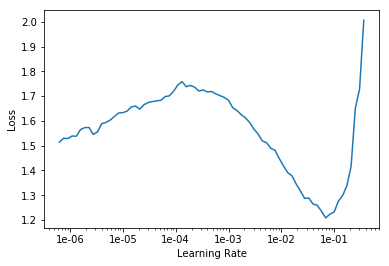

In [21]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.lr_find()
learn.recorder.plot()